In [1]:
import os
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline

from utils import *

assert "data" in os.listdir(), "No data folder found, please download the CSVs in a data/ folder!"

DATA_DIR = Path("data")
PLOT_DIR = Path("plots")
PLOT_DIR.mkdir(parents=True, exist_ok=True)

# Perform tests on population to determine no significant difference in age, gender and familiarity with technology is present

## Chi-squared test for homogeneity

In [11]:
def read_experiment_data(data_file, group):
    data_df = pd.read_csv(DATA_DIR / data_file)
    data_df = data_df.dropna(subset=['user_id'])
    data_df['user_id'] = data_df['user_id'].astype(int)
    data_df['group'] = group

    data_df.fillna({
        'Gender': 'male',
        'Familiarity with LLMs': 5,
        'Age': 24
    }, inplace=True)

    data_df['Gender'] = data_df['Gender'].str.lower()

    return data_df

In [13]:
exp_df = read_experiment_data("DSAIT 4065 Experiment Tracking Spreadsheet - Semantic.csv", "experimental")
ctrl_df = read_experiment_data("DSAIT 4065 Experiment Tracking Spreadsheet - Episodic.csv", "control")

# Combine the data
combined_df = pd.concat([exp_df, ctrl_df])

# Create a contingency table: rows = gender, columns = group
contingency_table = pd.crosstab(combined_df["Gender"], combined_df["group"])

print("Contingency Table:")
print(contingency_table)

# Perform Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"\nChi-square statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p}")

alpha = 0.05
if p < alpha:
    print("\nResult: Reject the null hypothesis — gender distribution is significantly different between groups.")
else:
    print("\nResult: Fail to reject the null hypothesis — gender distribution is not significantly different between groups.")

Contingency Table:
group   control  experimental
Gender                       
female        2             1
male         13            14

Chi-square statistic: 0.0
Degrees of freedom: 1
P-value: 1.0

Result: Fail to reject the null hypothesis — gender distribution is not significantly different between groups.


## Kruskal-Wallis test was used to check for significant differences in age and familiarity with LLMs of the participants between the two groups

In [22]:
age_exp = exp_df['Age']
age_ctrl = ctrl_df['Age']

# Kruskal-Wallis test for age
kruskal_age_stat, kruskal_age_p = stats.kruskal(age_exp, age_ctrl)

print(f"\nKruskal-Wallis test for Age:")
print(f"Statistic: {kruskal_age_stat}")
print(f"P-value: {kruskal_age_p}")

if kruskal_age_p < alpha:
    print("\nResult: Reject the null hypothesis — significant differences in age between groups.")
else:
    print("\nResult: Fail to reject the null hypothesis — no significant differences in age between groups.")

# --- Kruskal-Wallis test for Familiarity with LLMs ---
exp_df['Familiarity with LLMs'] = pd.to_numeric(exp_df['Familiarity with LLMs'], errors='coerce')
ctrl_df['Familiarity with LLMs'] = pd.to_numeric(ctrl_df['Familiarity with LLMs'], errors='coerce')

familiarity_exp = exp_df['Familiarity with LLMs']
familiarity_ctrl = ctrl_df['Familiarity with LLMs']

# Kruskal-Wallis test for familiarity with LLMs
kruskal_familiarity_stat, kruskal_familiarity_p = stats.kruskal(familiarity_exp, familiarity_ctrl)

print(f"\nKruskal-Wallis test for Familiarity with LLMs:")
print(f"Statistic: {kruskal_familiarity_stat}")
print(f"P-value: {kruskal_familiarity_p}")

if kruskal_familiarity_p < alpha:
    print("\nResult: Reject the null hypothesis — significant differences in familiarity with LLMs between groups.")
else:
    print("\nResult: Fail to reject the null hypothesis — no significant differences in familiarity with LLMs between groups.")


Kruskal-Wallis test for Age:
Statistic: 0.3568498769483082
P-value: 0.5502609595647867

Result: Fail to reject the null hypothesis — no significant differences in age between groups.
Experimental Group familiarity data count: 15
Control Group familiarity data count: 15

Kruskal-Wallis test for Familiarity with LLMs:
Statistic: 0.26825396825398645
P-value: 0.6045054371054662

Result: Fail to reject the null hypothesis — no significant differences in familiarity with LLMs between groups.


## Create semantic and eposidic survey dataframes from survey data

In [2]:
def split_survey_by_user(data_file, survey_file, category):
    data_df = pd.read_csv(data_file)
    survey_df = pd.read_csv(survey_file)

    user_ids = set(data_df['user_id'].dropna().astype(int))

    survey_df = survey_df.drop("Timestamp", axis=1)
    survey_df = survey_df.rename(columns={"Please fill in your user id that was used in the experiment.": "user_id"})

    survey_filtered_df = survey_df[survey_df['user_id'].dropna().astype(int).isin(user_ids)]

    output_file = DATA_DIR / f"Survey_{category}.csv"
    survey_filtered_df.to_csv(output_file, index=False)

    return survey_filtered_df

In [3]:
semantic_survey_df = split_survey_by_user(DATA_DIR / "DSAIT 4065 Experiment Tracking Spreadsheet - Semantic.csv", 
                                          DATA_DIR / "Survey Questionnaire for AI-Based TV Show_Movie Recommendations (Responses) - Form Responses 1.csv", 
                                          "Semantic")

episodic_survey_df = split_survey_by_user(DATA_DIR / "DSAIT 4065 Experiment Tracking Spreadsheet - Episodic.csv", 
                                          DATA_DIR / "Survey Questionnaire for AI-Based TV Show_Movie Recommendations (Responses) - Form Responses 1.csv", 
                                          "Episodic")


# Categorize questions and process the data to compute the measures

## Extract from evaluation report: 

The level of human trust in the recommender agent will be measured through an established questionnaire by Jian et al. (2000) (See Appendix). The questionnaire contains 12 questions all of which use a seven-point Likert scale to measure user trust in the agent, where 1 represents the weakest trust and 7 the strongest trust. Some questions assess the user's distrust in / incapabilities of the agent, and their values will be inverted to ensure that a score of 7 always represents the strongest trust. The mean value of the 12 questions will be computed for each participant, which will then be aggregated to produce one averaged value over all participants for each group. 


In [4]:
survey_questions = [
'The system is deceptive',
'The system behaves in an underhanded manner',
'I am suspicious of the system’s intent, action, or outputs',
'I am wary of the system',
'The system’s actions will have a harmful or injurious outcome',
'I am confident in the system', 'The system provides security',
'The system has integrity', 'The system is dependable',
'The system is reliable', 'I can trust the system',
'I am familiar with the system'
]

In [5]:
negative_questions = [
"The system is deceptive",
"The system behaves in an underhanded manner",
"I am suspicious of the system’s intent, action, or outputs",
"I am wary of the system",
"The system’s actions will have a harmful or injurious outcome"
]

In [6]:
def process_survey_data(df, survey_questions, negative_questions):
    df = df.copy()  # Avoid modifying the original dataframe

    # Reverse score the negative questions
    for question in negative_questions:
        if question in df.columns:
            df[question] = 8 - df[question]  # Invert scores (1 → 7, 2 → 6, ..., 7 → 1)

    # Compute mean trust score per user
    df['mean_trust_score'] = df[survey_questions].mean(axis=1)

    return df[['user_id', 'mean_trust_score']]

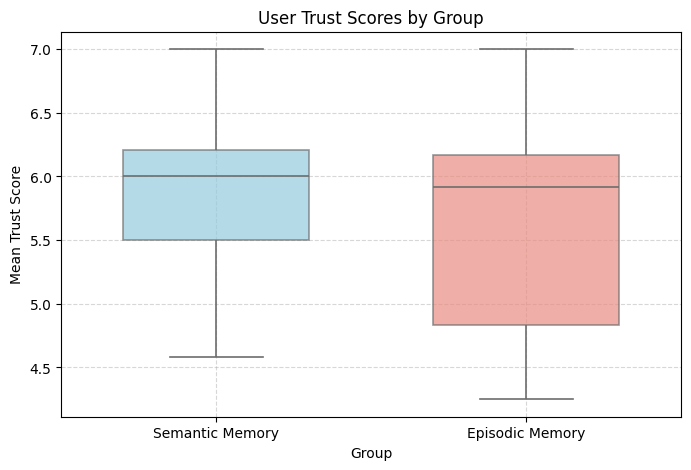

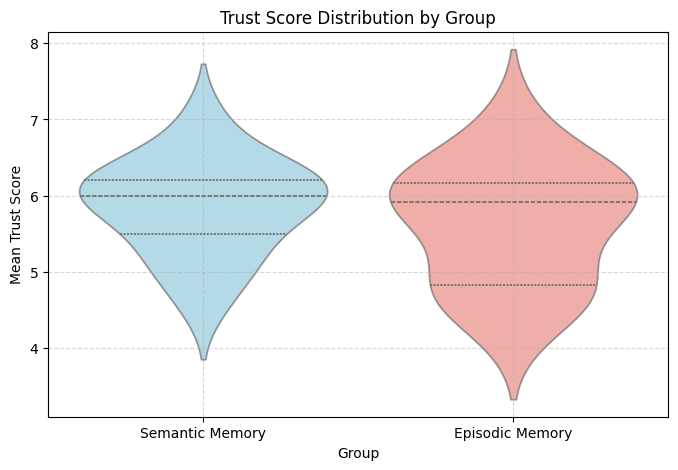

Plots saved successfully in: plots


In [7]:
semantic_user_trust = process_survey_data(semantic_survey_df, survey_questions, negative_questions)
episodic_user_trust = process_survey_data(episodic_survey_df, survey_questions, negative_questions)

semantic_user_trust["group"] = "Semantic Memory"
episodic_user_trust["group"] = "Episodic Memory"

combined_trust_df = pd.concat([semantic_user_trust, episodic_user_trust], ignore_index=True)

# Plot the scores
plot_and_save_trust_scores(combined_trust_df, PLOT_DIR)

# Statistical Testing

In [8]:
control_group = "Episodic Memory"
experimental_group = "Semantic Memory"

control_group_scores = combined_trust_df[combined_trust_df['group'] == control_group]['mean_trust_score']
experimental_group_scores = combined_trust_df[combined_trust_df['group'] == experimental_group]['mean_trust_score']

### Shapiro-Wilk test for normality

In [10]:
# Perform Shapiro-Wilk test for normality
control_shapiro_stat, control_p_value = stats.shapiro(control_group_scores)
experimental_shapiro_stat, experimental_p_value = stats.shapiro(experimental_group_scores)

print(f"Control Group - Shapiro-Wilk Test Statistic: {control_shapiro_stat}, p-value: {control_p_value}")
print(f"Experimental Group - Shapiro-Wilk Test Statistic: {experimental_shapiro_stat}, p-value: {experimental_p_value}")

# Interpret the results
if control_p_value > 0.05:
    print("Control group trust scores are normally distributed.")
else:
    print("Control group trust scores are not normally distributed.")
    
if experimental_p_value > 0.05:
    print("Experimental group trust scores are normally distributed.")
else:
    print("Experimental group trust scores are not normally distributed.")

Control Group - Shapiro-Wilk Test Statistic: 0.9488431327703856, p-value: 0.5064183445525734
Experimental Group - Shapiro-Wilk Test Statistic: 0.9740823510570769, p-value: 0.9132300009547094
Control group trust scores are normally distributed.
Experimental group trust scores are normally distributed.


### Bertlett's test for equi-variance

In [11]:
# Perform Bartlett's test
stat, p_value = stats.bartlett(control_group_scores, experimental_group_scores)

# Output the result
print(f"Bartlett's test statistic: {stat:.3f}, p-value: {p_value:.3f}")

# Interpretation
if p_value < 0.05:
    print("The variances are significantly different (reject H₀). Use Welch’s t-test.")
else:
    print("The variances are equal (fail to reject H₀).\n\nUse Student's t-test.")

Bartlett's test statistic: 0.725, p-value: 0.395
The variances are equal (fail to reject H₀).

Use Student's t-test.


## Latex Formatting for report

In [12]:
# Start the LaTeX table header for Shapiro-Wilk test results
latex_header = r"""
\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
Group & W-Statistic & p-value & Normality \\
\hline
"""

# Initialize an empty string for the rows
latex_rows = ""

# Define model shorthand for the groups (e.g., "Control" and "Experimental")
group_names_shorthand = {
    "Episodic Memory": "Control Group (Episodic)",
    "Semantic Memory": "Experimental Group (Semantic)"
}

# Perform the Shapiro-Wilk test for normality and format the results
for group in [control_group, experimental_group]:
    # Get the trust scores for the current group
    group_scores = combined_trust_df[combined_trust_df['group'] == group]['mean_trust_score']
    
    # Perform the Shapiro-Wilk test
    w_stat, p_value = stats.shapiro(group_scores)
    
    # Determine normality based on the p-value
    normality = "\\textbf{Yes}" if p_value > 0.05 else "\\textbf{No}"
    
    # Add the row to the LaTeX table (formatting numbers to a fixed precision)
    latex_rows += f"{group_names_shorthand[group]} & {w_stat:.3f} & {p_value:.3f} & {normality} \\\\ \n"

# End the LaTeX table
latex_footer = r"""
\hline
\end{tabular}
\caption{Shapiro-Wilk Test Results for Normality of User Trust Scores}
\label{tab:shapiro_results}
\end{table}
"""

# Combine header, rows, and footer
latex_output = latex_header + latex_rows + latex_footer

# Print the LaTeX table output
print(latex_output)


\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
Group & W-Statistic & p-value & Normality \\
\hline
Control Group (Episodic) & 0.949 & 0.506 & \textbf{Yes} \\ 
Experimental Group (Semantic) & 0.974 & 0.913 & \textbf{Yes} \\ 

\hline
\end{tabular}
\caption{Shapiro-Wilk Test Results for Normality of User Trust Scores}
\label{tab:shapiro_results}
\end{table}



# Independent samples t-test (Student’s t-test)

### Research Question:
The primary goal of this analysis is to evaluate whether there is a significant difference in the mean user trust scores between the **control group** (episodic memory) and the **experimental group** (semantic memory) in the context of a movie/series recommender agent.

### Hypotheses:
- **Null Hypothesis (H₀)**: There is no significant difference in the mean user trust scores between the control group (episodic memory) and the experimental group (semantic memory).
- **Alternative Hypothesis (H₁)**: There is a significant difference in the mean user trust scores between the control group (episodic memory) and the experimental group (semantic memory).

### Statistical Test:
Since we are comparing the means of two independent groups (control and experimental), we will perform an **independent samples t-test** (Student’s t-test). This test helps determine whether there is a statistically significant difference between the mean trust scores of the two groups.


In [13]:
# Perform the independent t-test (two-tailed)
t_stat, p_value = stats.ttest_ind(control_group_scores, experimental_group_scores)

# Print the test result
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Determine whether the null hypothesis is rejected
alpha = 0.05  # Significance level (5%)

if p_value < alpha:
    result = "Reject the null hypothesis: There is a significant difference in the mean trust scores."
else:
    result = "Fail to reject the null hypothesis: There is no significant difference in the mean trust scores."

print(result)

T-statistic: -0.894
P-value: 0.379
Fail to reject the null hypothesis: There is no significant difference in the mean trust scores.


## Latex Formatting for report

In [14]:
# Start the LaTeX table header for t-test results
latex_header = r"""
\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
Group A & Group B & T-Statistic & p-value \\
\hline
"""

# Define group names for the table
group_names_shorthand = {
    "episodic": "Control Group (Episodic)",
    "semantic": "Experimental Group (Semantic)"
}

# Add the t-test results to the LaTeX table
latex_rows = f"{group_names_shorthand['episodic']} & {group_names_shorthand['semantic']} & {t_stat:.3f} & {p_value:.3f} \\\\ \n"

# End the LaTeX table
latex_footer = r"""
\hline
\end{tabular}
\caption{Independent Samples T-Test Results for User Trust Scores}
\label{tab:t_test_results}
\end{table}
"""

# Combine header, rows, and footer
latex_output = latex_header + latex_rows + latex_footer

# Print the LaTeX table output
print(latex_output)



\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
Group A & Group B & T-Statistic & p-value \\
\hline
Control Group (Episodic) & Experimental Group (Semantic) & -0.894 & 0.379 \\ 

\hline
\end{tabular}
\caption{Independent Samples T-Test Results for User Trust Scores}
\label{tab:t_test_results}
\end{table}

